In [64]:
#!pip install imutils

In [65]:
#!pip install pytesseract

In [66]:
#!pip install easyocr

https://omes-va.com/reconocimiento-de-matriculas-vehiculares-opencv-pytesseract-ocr-python/

https://www.marindelafuente.com.ar/reconocimiento-de-matriculas-con-raspberry-pi-y-opencv/

In [67]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import imutils
import pytesseract
from PIL import Image
import easyocr
import os
import pandas as pd

In [68]:
fotos = os.listdir('static/plates')
fotos

['Cars18.png',
 'Cars3.png',
 'Cars0.png',
 'Cars1.png',
 'Cars4.png',
 'Cars6.png',
 'Cars11.png',
 'Cars8.png',
 'Cars13.png',
 'Cars17.png',
 'Cars16.png',
 'Cars14.png',
 'Cars15.png']

Aqui se guarda en Azul, verde y Rojo y saldrian incorrectos frente a la original, predomina el azul frente al verde y asi..  Porque si no cambiamos el color, matplotlib, nos lo muestra normalmente el color incorrecto, y matplotlib espera una reconversion a RGB


In [69]:
#img = cv.imread('suzuki.jpeg')
#plt.imshow(img)

Cuando cargas una imagen con OpenCV y la muestras directamente en matplotlib sin realizar ninguna conversión de espacio de color, los canales de color se interpretan incorrectamente, lo que lleva a una representación incorrecta de los colores.

Al convertir la imagen de BGR a RGB utilizando ```cv.cvtColor()```, estás cambiando el orden de los canales de color para que se ajuste a la interpretación correcta de matplotlib. De esta manera, los colores se muestran correctamente en la imagen.

En resumen, la conversión de BGR a RGB es necesaria para mostrar los colores correctamente en matplotlib, ya que esta biblioteca espera la convención RGB para la representación de colores.

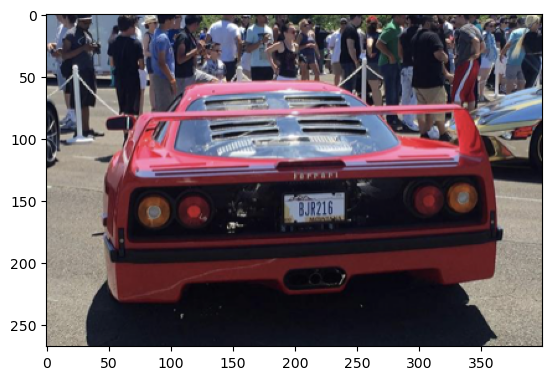

In [97]:
# Convertimos la imagen a Rojo, Verde y Azul y asi la mostramos original
img = cv.imread('static/plates/Cars13.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

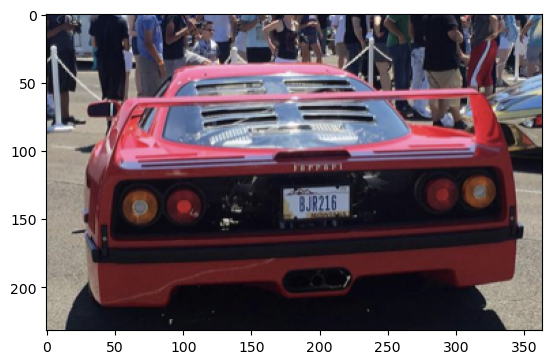

In [98]:
# Recortamos la imagen
alto, ancho, _ = img.shape

margen = 18
# Definir las coordenadas para el recorte
x1 = margen
y1 = margen
x2 = ancho - margen
y2 = alto - margen

# Recortar la imagen
img = img[y1:y2, x1:x2]
plt.imshow(img)

Redimensionar nos ayuda a **evitar cualquier problema con imágenes de mayor resolución**, asegurándonos de que la matrícula permanece en el marco después del redimensionamiento. 

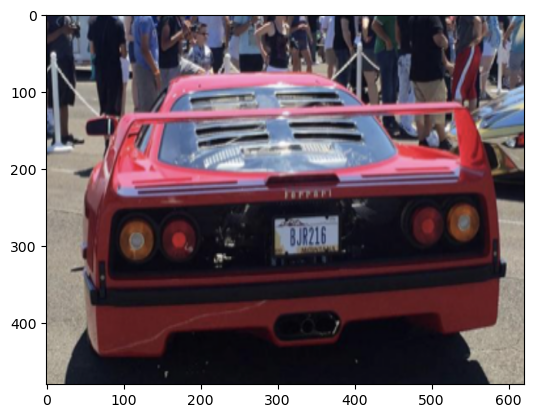

In [99]:
# Cambiamos el tamaño 
img = cv.resize(img, (620,480) )
plt.imshow(img)

## Escala de grises

La escala de grises es común en todos los pasos de procesamiento de imágenes. Esto acelera otros procesos posteriores, ya no tenemos que ocuparnos de los detalles de color cuando procesamos una imagen. 

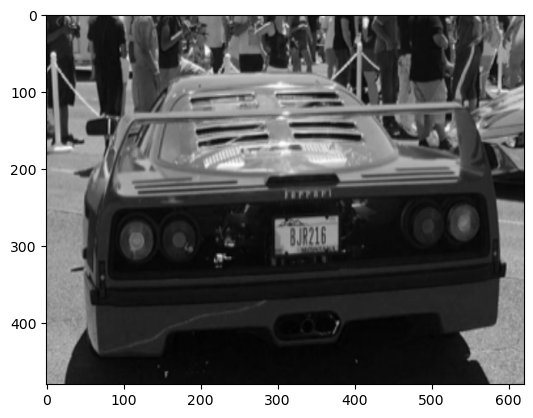

In [100]:
# Convertimos a escala de grises
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #convert to grey scale
#gray
plt.imshow(gray,cmap='gray') #Aqui especificamos que lo queremos en el color gris

## Difuminar

Cada imagen tiene informacion util e inservible, en este caso queremos solo la matricula, por lo tanto el resto no nos importa, aqui usamos un filtro ``` bilateral(bluring) ```



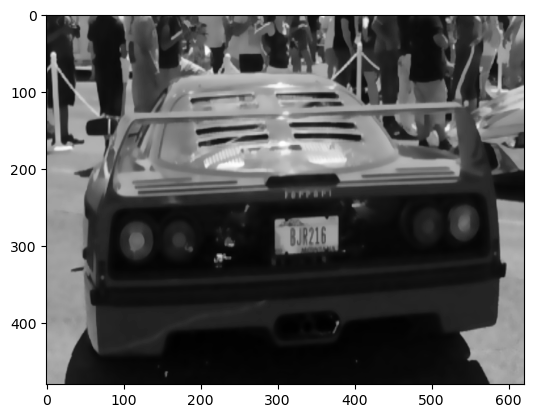

In [101]:
# Difuminamos la parte inutil de la foto
gray = cv.bilateralFilter(gray, 11, 17, 17)
plt.imshow(gray, cmap='gray')

Aqui estaria la sintaxis de la función, ``` destination_image = cv2.bilateralFilter(imagen_fuente, diámetro del píxel, sigmaColor, sigmaSpace) ```

Ten cuidado que la parte util no se difumine, como vemos aqui en la imagen que nos muestra, se ha difuminado los coches, y los arboles de alrededor, demostrando que no son utilies.


## Bordes

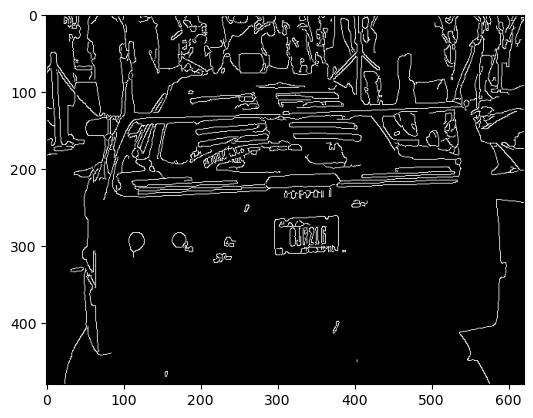

In [102]:
# Sacamos los contornos de la foto para averiguar la matricula 
edged = cv.Canny(gray, 30, 200) #Perform Edge detection
plt.imshow(edged, cmap='gray')

El siguiente paso es interesante cuando realizamos la detección de bordes. Hay muchas maneras de hacerlo, la más fácil y popular es usar el ``` método canny edge de OpenCV```

La sintaxis será ``` destination_image = cv2.Canny(source_image, thresholdValue 1, thresholdValue 2)```. El valor umbral 1 (thresholdValue 1)y el valor umbral 2 (thresholdValue 2) son los valores umbral mínimo y máximo. Sólo se mostrarán los bordes que tengan un gradiente de intensidad superior al valor umbral mínimo e inferior al valor umbral máximo.

## Contornos

En nuestra imagen el contador puede ser cualquier cosa que tenga una superficie cerrada pero de todos los resultados obtenidos el número de placa también estará allí ya que es también una superficie cerrada.

In [115]:
# Contamos los contornos cerrados que hay en la imagen
cnts = cv.findContours(edged.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:100]
screenCnt = None


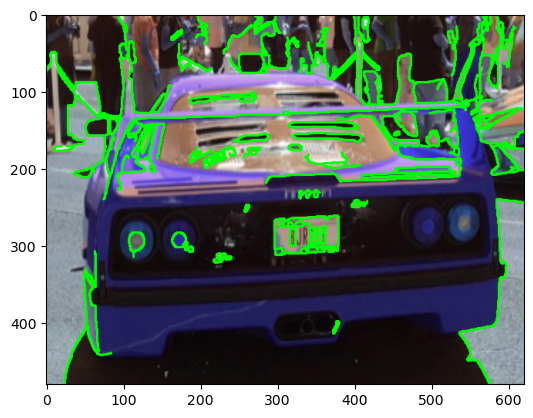

In [116]:
# Aquí se muestra cómo dibujar los contornos en la imagen original.
image_with_contours = img.copy()
cv.drawContours(image_with_contours, cnts, -1, (0, 255, 0), 2)  # Dibuja todos los contornos en verde

# Muestra la imagen con los contornos
plt.imshow(cv.cvtColor(image_with_contours, cv.COLOR_BGR2RGB))
plt.show()

Para filtrar la imagen de la matrícula entre los resultados obtenidos, recorreremos todos los resultados y comprobaremos cuál tiene un contorno en forma con 6 lados y una figura cerrada. Una matricula es rectangular, pero en este caso reconoce la matricula como 6 grados como hemos visto anteriormente.

Lo podemos hacer de dos formas:


1. Hacer un loop para sacar el contorno donde este la matricula

In [107]:
# Hacemos un bucle por todos los contornos que tenemos 
for c in cnts:
                # approximate the contour
                peri = cv.arcLength(c, True)
                approx = cv.approxPolyDP(c, 0.018 * peri, True)
                # si nuestro contorno mas similar tiene 4 lados, entonces
                # asumimos que lo hemos encontrado, por eso paramos
                if len(approx) == 4:
                      screenCnt = approx
                      break

2. Sacamos todos los lados del rectangulo

Obtenemos los puntos ``` x, y, w y h ``` que rodean a cada contorno, esto nos ayudará para luego determinar el aspect ratio del contorno y determinar que se trate de un rectángulo.

Obtenemos approx, que es en donde se almacenará el número de vértices del contorno, para ello usamos la función ``` cv2.approxPolyDP ``` que a su vez usa epsilon del medio. Aquí el porcentaje que he usado es de 9%, pero tu podrías cambiarlo para experimentar.

In [62]:
#x,y,w,h = cv.boundingRect(c)
#epsilon = 0.09*cv.arcLength(c,True)
#approx = cv.approxPolyDP(c,epsilon,True)

Hemos encontrado el contorno de la matricula, rectangular con 6 puntos cerrados por todos sus lados y ahora la visualizamos para ver si lo hemos hecho bien.

In [108]:
print(screenCnt)

[[[321 155]]

 [[323 161]]

 [[401 165]]

 [[409 159]]]


## Representación

Ahora que sabemos dónde está la matrícula, el resto de la información es bastante inútil para nosotros. Así que podemos proceder a enmascarar toda la imagen excepto el lugar donde está la matrícula. El código para hacer lo mismo se muestra a continuación:

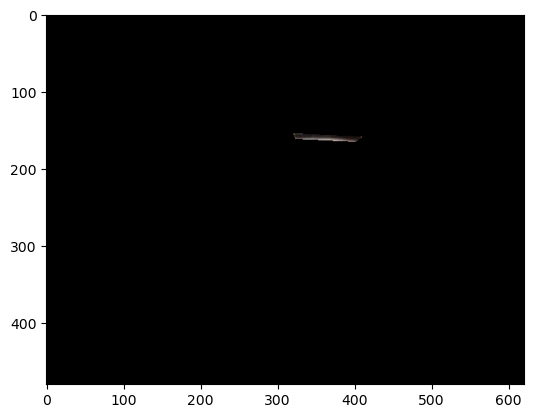

In [109]:
# Dibuja el contorno de la matrícula en una imagen en blanco
mask = np.zeros_like(img)
cv.drawContours(mask, [screenCnt], -1, (255, 255, 255), -1)

# Aplica la máscara para obtener solo la región de la matrícula
license_plate = cv.bitwise_and(img, mask)

# Muestra la región de la matrícula
plt.imshow(cv.cvtColor(license_plate, cv.COLOR_BGR2RGB))
#plt.imshow()


## Lectura de la matricula

Instalara tesseract para reconocimiento de imagenes y matriculas.
- Para windows :  https://omes-va.com/como-instalar-tesseract-orc-y-pytesseract-en-windows/
    - https://github.com/UB-Mannheim/tesseract/wiki
- Para Mac :  https://tesseract-ocr.github.io/tessdoc/Installation.html#:~:text=tesseract%20page.-,Homebrew,-To%20install%20Tesseract

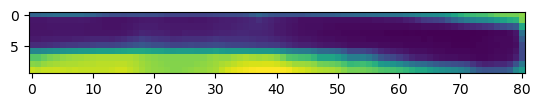

In [110]:
indices = np.where(mask == 255)
x = indices[0]
y = indices[1]
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
# Topx +1 recortamos desde arriba, Bottomx +1 alargamos hacia abajo (Vertical)
# Topy +1 acorta hacia la derecha, Bottomy +1 alarga hacia la derecha (Horizontal)
Cropped = gray[topx:bottomx, topy+7:bottomy]
plt.imshow(Cropped)

In [111]:
# Leer la placa con pytesseract
#placa = gray[y:y+h,x:x+w]
config = '--psm 11'
text = pytesseract.image_to_string(Cropped,config=config)
print('El numero de matricula es: ',text)

El numero de matricula es:  


In [112]:
# Leer con Easy OCR

reader = easyocr.Reader(['es'])
result = reader.readtext(Cropped)
result

[]

In [28]:
matriculas = []

In [29]:
# Aqui tenemos la matricula de nuestra imagen
x = result[0][1]

In [30]:
matriculas.append(x)

In [32]:
matriculas.append('9287 LKG')

In [37]:
matriculas

['9227 LKG', '9287 LKG']

In [41]:
df = pd.DataFrame({'plates':matriculas})
df

,plates
0,9227 LKG
1,9287 LKG


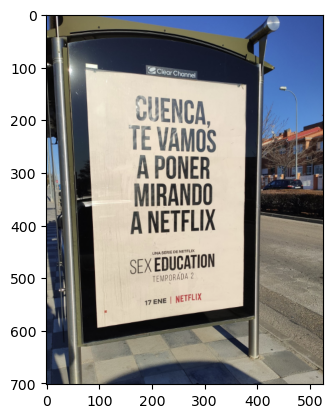

In [184]:
# Leemos la imagen
img = cv.imread('static/cuenca.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

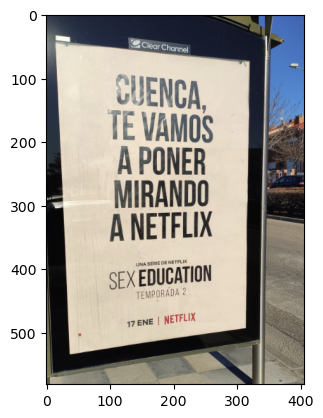

In [157]:
# Recortamos la imagen
alto, ancho, _ = img.shape

margen = 60
# Definir las coordenadas para el recorte
x1 = margen
y1 = margen
x2 = ancho - margen
y2 = alto - margen

# Recortar la imagen
img = img[y1:y2, x1:x2]
plt.imshow(img)

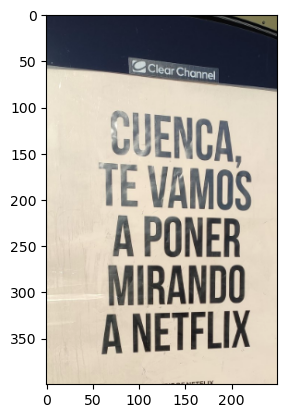

In [185]:
#img = img[vertical,horizontal]
img = img[50:450, 100:350]
plt.imshow(img)

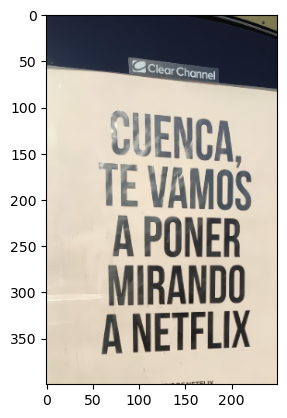

In [186]:
gray = cv.bilateralFilter(img, 11, 17, 17)
plt.imshow(gray, cmap='gray')

In [187]:
reader = easyocr.Reader(['es'])
result = reader.readtext(gray)
result

[([[109, 53], [141, 53], [141, 69], [109, 69]], 'Clear', 0.9813446654488693),
 ([[58, 96], [219, 96], [219, 172], [58, 172]],
  'CUENCA ,',
  0.25688111054485285),
 ([[53, 155], [234, 155], [234, 222], [53, 222]],
  'TE VAMOS',
  0.7022822663944025),
 ([[69, 211], [221, 211], [221, 271], [69, 271]],
  'A PONER',
  0.9757700268013497),
 ([[63, 265], [225, 265], [225, 325], [63, 325]],
  'MIRANDO',
  0.9823780714289575),
 ([[88, 316], [228, 316], [228, 372], [88, 372]],
  'NETFLIX',
  0.8851462471351277),
 ([[141.53425356716738, 55.115081777618016],
   [187.98909017788182, 61.852688696911216],
   [185.46574643283262, 75.88491822238198],
   [139.01090982211818, 69.14731130308878]],
  'Chonnel',
  0.9114932642787621)]

In [188]:
valores_detecciones = []
for deteccion in result:
    texto = deteccion[1]
    valores_detecciones.append(texto)
valores_detecciones

['Clear', 'CUENCA ,', 'TE VAMOS', 'A PONER', 'MIRANDO', 'NETFLIX', 'Chonnel']